# Compare groups

## Statistical comparison

Very often we need to compare two groups of users using some metrics. It can be during A/B test results analysis, or comparison two user segments from different channels, or comparing cohorts of users and etc.

In this tutorial we will use simple dataset of user activity logs in app or web-site during hypothetical A/B test. It has raw behavior event-level logs as well as additional information, specifying was particular user in the test or control and some transaction information.

We start from importing retentioneering and sample datasets:

In [1]:
import retentioneering

# load sample data
data = retentioneering.datasets.load_simple_ab_test()

data.head()

,user_id,event,timestamp,user_backet,transaction_value,transaction_ID
0,219483890,catalog,2019-11-01 17:59:13.273932,test,NaN,None
1,219483890,product,2019-11-01 17:59:28.459271,test,NaN,None
2,219483890,cart,2019-11-01 17:59:29.502214,test,NaN,None
3,219483890,catalog,2019-11-01 17:59:32.557029,test,NaN,None
4,964964743,catalog,2019-11-01 21:38:19.283663,test,NaN,None


We can see regular columns with information about user actions (‘user_id’, ‘event’, ‘timestamp’) as well as column regarding A/B test: ‘user_backet’, and columns with transactions information (events ‘payment_done’): ‘transaction_value’ and ‘transaction_ID’.

Next, as usually we need to update retentioneering.config to specify column names for events, user_ids and time:

In [2]:
retentioneering.config.update({
    'user_col': 'user_id',
    'event_col':'event',
    'event_time_col':'timestamp',
})

Let’s explore column ‘user_backet’:

In [3]:
(data
 .drop_duplicates(subset=['user_id'])['user_backet']
 .value_counts())

not_in_test    2624
control         573
test            554
Name: user_backet, dtype: int64

We can see that our dataset has 554 and 573 unique users in test and control groups, correspondingly. Let’s put those user_id’s in separate variables ‘test’ and ‘control’:

In [4]:
test = data[data['user_backet']=='test']['user_id'].unique()
control = data[data['user_backet']=='control']['user_id'].unique()

Now everything is ready to start comparing these two groups using rete.compare() function.

Let’s say we would like to compare conversion rate in the test vs control groups.

For this we would need to specify function that given one user trajectory (in form of dataframe) will return a numerical value, 1 (converted) or 0 (not converted) in our case. Importantly, functiuon must take as an argument a dataframe of one user trajectory, performs any type of calculation and return a single numerical value.

In our case user is considered converted is they have ‘payment_done’ event, so the function definition is very straightforward:

test (mean ± SD): 0.227 ± 0.419, n = 554
control (mean ± SD): 0.148 ± 0.355, n = 573
'test' is greater than 'control' with P-value: 0.00034


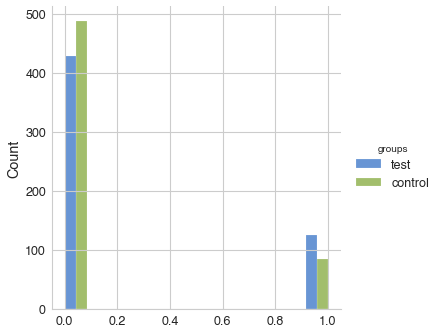

In [5]:
conversion = lambda x: int(['payment_done'] in x['event'].unique())

data.rete.compare(groups=(test, control),
                  function=conversion,
                  test='mannwhitneyu',
                  group_names=('test','control'))

Parameters for function rete.compare():

* groups: tuple (g1, g2), where g1 and g2 are collections of user_id`s (list, tuple or set) of two groups for comparison.

* function(x): function that takes single user dataset as an argument and returns a single numerical value (see below for more examples).

* test: {‘ks_2samp’, ‘mannwhitneyu’}, selected statistical test to test the null hypothesis that 2 independent samples are drawn from the same distribution. One-sided tests are used, meaning that distributions are compared for ‘less’ or ‘greater’. For discrete variables (like conversions, number of purchases) use Mann-Whitney test (‘mannwhitneyu’). For continious variables (like average_check) use Kolmogorov-Smirnov test (‘ks_2samp’).

* group_names - optional parameter to set group names for the output.

We can see that in the example above test group have statistically significantly higher conversion rate than control group (given P-value threshold for significance 0.05), threfore change must be implemented. Histogram just illustrates how the selected metric is distributed between groups (in the example above metrics can only be 0 or 1).

To illustrate better how to define custom metrics and pass it as an argument to rete.compare() function let’s compare couple more metrics. Suppose we would like to compare average check between test and control groups. Again, it’s very easy:



test (mean ± SD): 736.026 ± 149.001, n = 126
control (mean ± SD): 732.980 ± 139.960, n = 85
'test' is less than 'control' with P-value: 0.55199


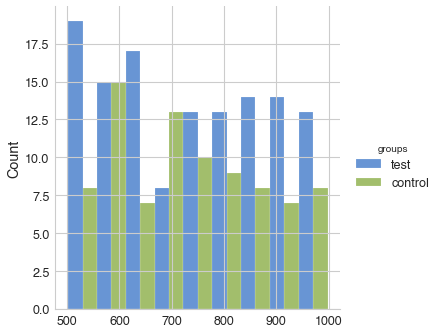

In [6]:
average_check = lambda x: x['transaction_value'].mean()


data.rete.compare(groups=(test, control),
                  function=average_check,
                  test='ks_2samp',
                  group_names=('test','control'))

In this case we can see that there is no statistically significant difference in average checks between two groups (P-value is 0.55, selected threshold is 0.05). Note, that for continious variable like average check we used Kolmogorov-Smirnov test. While we can conclude that users in the test group converted to purchase more often than in control group, there was no effect on the average check.

## More complex metrics

Just to illustrate that metrics function can be any complex, let’s consider another example. Suppose we have separate file, which has all transaction_id’s and their statuses (whether transaction was already confirmed by bank or not).

For the demonstration purpose let’s just create such dataframe with randomized data:

In [7]:
import pandas as pd
import random

all_ids = data['transaction_ID'].dropna().unique()
status = pd.DataFrame({'transaction_ID': all_ids, 
                       'confirmed': [random.random() > 0.2 
                                     for _ in all_ids]})

status.head()

,transaction_ID,confirmed
0,7121884,True
1,9641982,True
2,9826287,False
3,9647603,True
4,8125650,True


Now, let’s write metrics function confirmed_purch, which will return 1 if user has confirmed transactions or 0 if has not:

In [8]:
def confirmed_purch(x):
    
    # get list of transactions for user x
    trans_list = x['transaction_ID'].unique()
    
    # get all status records for transactions from user x
    trans_status = status[status['transaction_ID'].isin(trans_list)]
    
    # True / False if user has conf transactions
    has_conf_trans = trans_status['confirmed'].sum() > 0
    
    # convert bool to int:
    return int(has_conf_trans)


It’s very straightforward. Again, function confirmed_purch() takes single user trajecotry as an argument (as pandas dataframe) and returns a single numerical value. Let’s compare our groups using confirmed_purch metric:

test (mean ± SD): 0.197 ± 0.398, n = 554
control (mean ± SD): 0.120 ± 0.325, n = 573
'test' is greater than 'control' with P-value: 0.00022


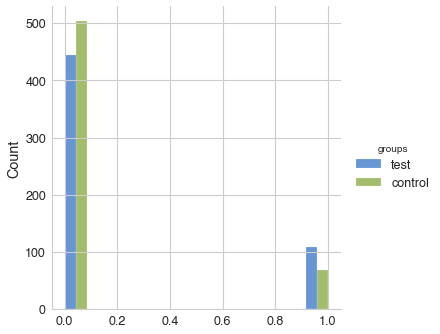

In [9]:
data.rete.compare(groups=(test, control),
                  function=confirmed_purch,
                  test='mannwhitneyu',
                  group_names=('test','control'))

As we can see, statistically significant difference in the conversion to confirmed purchases still holds with selected significance level 0.05.